In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

FOLDER_PATH = 'CSV_Outputs/BidAsk2/'

In [13]:
imcDF = pd.read_csv('IMC_Data.csv', usecols=['timestamp', 'product', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2','ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2' ] )
imcDF.set_index('timestamp', inplace=True)

starfruit = imcDF[imcDF['product'] == 'STARFRUIT'].drop(columns=['product'])

trade_log = []
position_open = False
position_type = None
endRow = 1

for timestamp, row in starfruit.iterrows():
    
    historicalData = starfruit.iloc[:endRow]

    bp1 = row['bid_price_1']
    ap1 = row['ask_price_1']
    bp2 = row['bid_price_2']
    ap2 = row['ask_price_2']
    bv1 = row['bid_volume_1']
    av1 = row['ask_volume_1']
    bv2 = row['bid_volume_2']
    av2 = row['ask_volume_2']

    bpGap = abs(bp1 - bp2)
    apGap = abs(ap1 - ap2)

    if not position_open:
        if ap2 < bp1:
            trade_log.append({
                'timestamp': timestamp,
                'action': 'open position',
                'type': 'long',
                'price': ap2,
                'shares': bv1
            })
            trade_log.append({
                'timestamp': timestamp,
                'action': 'close position',
                'type': 'long',
                'price': bp1,
                'shares': bv1
            })

        elif bp2 > ap1:
            trade_log.append({
                'timestamp': timestamp,
                'action': 'open position',
                'type': 'short',
                'price': bp2,
                'shares': av1
            })
            trade_log.append({
                'timestamp': timestamp,
                'action': 'close position',
                'type': 'short',
                'price': ap1,
                'shares': av1
            })
    endRow += 1

trade_logDF = pd.DataFrame(trade_log)
trade_logDF.set_index('timestamp', inplace=True)
destinationPath = os.path.join(FOLDER_PATH, 'trade_log.csv')
trade_logDF.to_csv(destinationPath)

totalReturns = 0
openPosition = None
closePositionDates = []
closePositionReturns = []

for index, trade in trade_logDF.iterrows():
    if trade['action'] == 'open position':
        openPosition = trade
    elif trade['action'] == 'close position' and openPosition is not None:
        closePositionDates.append(trade.index[0])

        if openPosition['type'] == 'long':
            returns = (trade['price'] - openPosition['price']) * openPosition['shares']
        elif openPosition['type'] == 'short':
            returns = (openPosition['price'] - trade['price']) * openPosition['shares']
        
        totalReturns += returns
        closePositionReturns.append(returns)
        openPosition = None

pnlDf = pd.DataFrame(closePositionReturns, index=closePositionDates, columns=['pnl'])
pnlDf['cumulative_pnl'] = pnlDf['pnl'].cumsum()
pnlDf.reset_index(inplace=True, names='timestamp')

destination_path = os.path.join(FOLDER_PATH, 'pnl.csv')
pnlDf.to_csv(destination_path, index=False)



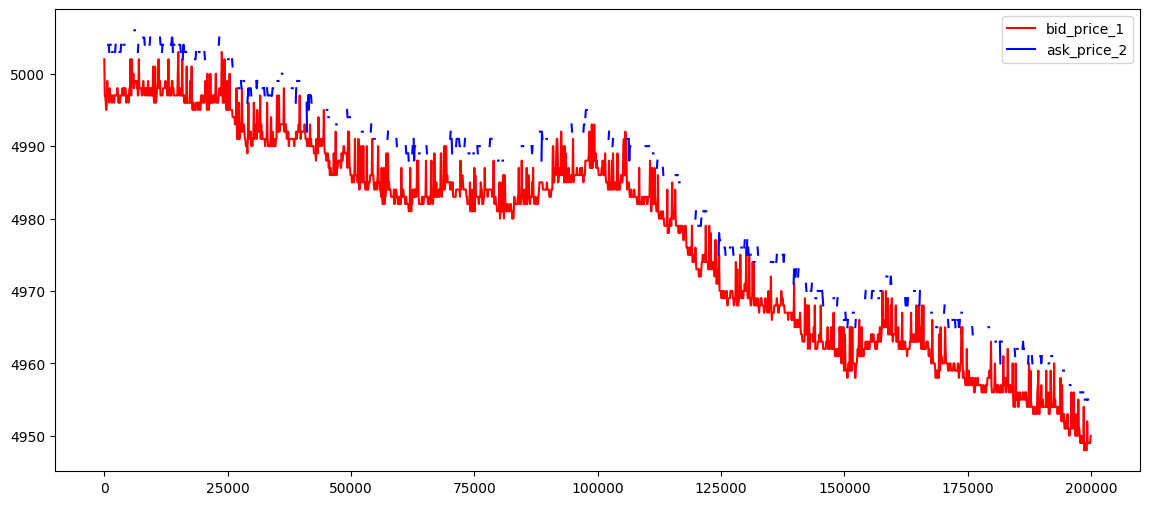

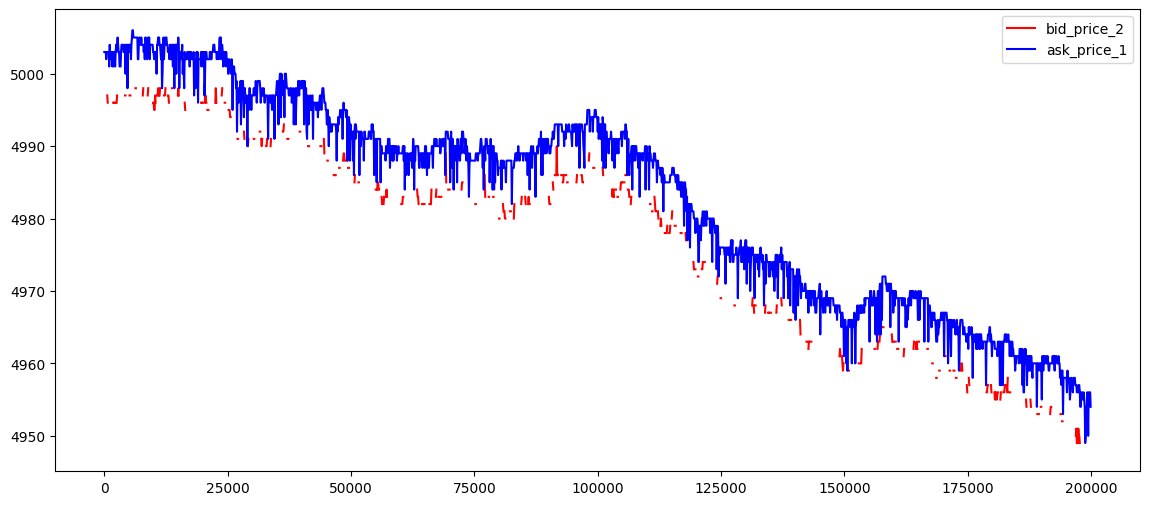

In [24]:
crossings = starfruit.where(starfruit['ask_price_2'] < starfruit['bid_price_1']).dropna()
crossings2 = starfruit.where(starfruit['bid_price_2'] > starfruit['ask_price_1']).dropna()

# Long Signal crossings
plt.figure(figsize=(14, 6))
plt.plot(starfruit.index, starfruit['bid_price_1'], label='bid_price_1', color='red')
plt.plot(starfruit.index, starfruit['ask_price_2'], label='ask_price_2', color='blue')

for idx in crossings.index:
    plt.axvline(x=idx, color='green', linestyle='--')

plt.legend()
plt.show()

# Short Signal crossings
plt.figure(figsize=(14, 6))
plt.plot(starfruit.index, starfruit['bid_price_2'], label='bid_price_2', color='red')
plt.plot(starfruit.index, starfruit['ask_price_1'], label='ask_price_1', color='blue')

for idx in crossings2.index:
    plt.axvline(x=idx, color='purple', linestyle='--')

plt.legend()
plt.show()

